In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds




In [ ]:
EPOCHS = 10

In [ ]:
class ResidualUnit(tf.keras.Model):
    def __init__(self, filter_in, filter_out, kernel_size):
        super(ResidualUnit, self).__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        if filter_in == filter_out:
            self.identity = lambda x: x
        else:
            self.identity = tf.keras.layers.Conv2D(filter_out, (1,1), padding='same')

    def call(self, x, training=False, mask=None):
        h = self.bn1(x, training=training)
        h = tf.nn.relu(h)
        h = self.conv1(h)
        
        h = self.bn2(h, training=training)
        h = tf.nn.relu(h)
        h = self.conv2(h)
        return self.identity(x) + h

In [ ]:
class ResnetLayer(tf.keras.Model):
    def __init__(self, filter_in, filters, kernel_size):
        super(ResnetLayer, self).__init__()
        self.sequence = list()
        for f_in, f_out in zip([filter_in] + list(filters), filters):
            self.sequence.append(ResidualUnit(f_in, f_out, kernel_size))

    def call(self, x, training=False, mask=None):
        for unit in self.sequence:
            x = unit(x, training=training)
        return x

In [ ]:
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu') # 28x28x8
        
        self.res1 = ResnetLayer(8, (16, 16), (3, 3)) # 28x28x16
        self.pool1 = tf.keras.layers.MaxPool2D((2, 2)) # 14x14x16
        
        self.res2 = ResnetLayer(16, (32, 32), (3, 3)) # 14x14x32
        self.pool2 = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32
        
        self.res3 = ResnetLayer(32, (64, 64), (3, 3)) # 7x7x64
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')
        
    def call(self, x, training=False, mask=None):
        x = self.conv1(x)
        
        x = self.res1(x, training=training)
        x = self.pool1(x)
        x = self.res2(x, training=training)
        x = self.pool2(x)
        x = self.res3(x, training=training)
        
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)
        

In [ ]:
# Implement training loop
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

# Implement algorithm test
@tf.function
def test_step(model, images, labels, loss_object, test_loss, test_accuracy):
    predictions = model(images, training=False)

    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [ ]:
(train_validation_ds, test_ds), ds_info = tfds.load(name='patch_camelyon',
                                                            shuffle_files=True,
                                                            as_supervised=True,
                                                            split=['train', 'test'],
                                                            with_info=True)
    
n_train_validation = ds_info.splits['train'].num_examples
    
train_ratio = 0.8
n_train = int(n_train_validation * train_ratio)
n_validation = n_train_validation - n_train
    
train_ds = train_validation_ds.take(n_train)
remaining_ds = train_validation_ds.skip(n_train)
validation_ds = remaining_ds.take(n_validation)


def standardization(TRAIN_BATCH_SIZE, TEST_BATCH_SIZE):
    global train_ds, validation_ds, test_ds
    
    def stnd(images, labels):
        images = tf.cast(images, tf.float32) / 255.
        return (images, labels)
    
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteT3E7O2/patch_camelyon-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteT3E7O2/patch_camelyon-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteT3E7O2/patch_camelyon-validation.tfrecord


Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Create model
model = ResNet()

# Define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define performance metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)

    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels, loss_object, test_loss, test_accuracy)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

TypeError: ignored

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.patch camelyon.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

SyntaxError: ignored

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
y_train.shape

(50000, 1)

In [ ]:
y_train[:10]

array([[19],
       [29],
       [ 0],
       [11],
       [ 1],
       [86],
       [90],
       [28],
       [23],
       [31]])

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# VGGNet 논문에서 활용한 이미지 크기가 224x224x3 입니다.
# 그 모델을 그대로 가져오면 Pooling으로 인해 이미지가 너무 작아지기 때문에 모델의 구조를 조금 바꾸었습니다.
inputs = keras.Input(shape=(32, 32, 3))
x = inputs
x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(256, 3, activation='relu', padding="same")(x)
#x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dense(256)(x)
x = layers.Dense(10, activation='softmax')(x)
outputs = x

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_227 (Conv2D)          (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 8, 128)        

In [ ]:
pcam_builder = tfds.builder("patch_camelyon")

pcam_builder.download_and_prepare()


In [ ]:
print(pcam_builder.info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
# VGGNet 논문에서 활용한 이미지 크기가 224x224x3 입니다.
# 그 모델을 그대로 가져오면 Pooling으로 인해 이미지가 너무 작아지기 때문에 모델의 구조를 조금 바꾸었습니다.
inputs = keras.Input(shape=(32, 32, 3))
x = inputs
x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(256, 3, activation='relu', padding="same")(x)
#x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dense(256)(x)
x = layers.Dense(10, activation='softmax')(x)
outputs = x

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_231 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 128)        

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/5
1563/1563 [==============================] - 14s 9ms/step - loss: nan - accuracy: 0.0100
Epoch 2/5
1563/1563 [==============================] - 14s 9ms/step - loss: nan - accuracy: 0.0100
Epoch 3/5
1563/1563 [==============================] - 14s 9ms/step - loss: nan - accuracy: 0.0100
Epoch 4/5
1563/1563 [==============================] - 14s 9ms/step - loss: nan - accuracy: 0.0100
Epoch 5/5
1563/1563 [==============================] - 14s 9ms/step - loss: nan - accuracy: 0.0100
313/313 - 1s - loss: nan - accuracy: 0.0100


[nan, 0.009999999776482582]

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = inputs
#x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dense(128)(x)
x = layers.Dense(10, activation='softmax')(x)
outputs = x

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_237 (Conv2D)          (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_238 (Conv2D)          (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_239 (Conv2D)          (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_240 (Conv2D)          (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_241 (Conv2D)          (None, 32, 32, 128)      

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/5
   1/1563 [..............................] - ETA: 0s - loss: nan - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0127s vs `on_train_batch_end` time: 0.0194s). Check your callbacks.


1563/1563 [==============================] - 43s 27ms/step - loss: nan - accuracy: 0.0100
Epoch 2/5
1563/1563 [==============================] - 43s 28ms/step - loss: nan - accuracy: 0.0100
Epoch 3/5
1563/1563 [==============================] - 43s 28ms/step - loss: nan - accuracy: 0.0100
Epoch 4/5
1563/1563 [==============================] - 44s 28ms/step - loss: nan - accuracy: 0.0100
Epoch 5/5
1563/1563 [==============================] - 44s 28ms/step - loss: nan - accuracy: 0.0100
313/313 - 3s - loss: nan - accuracy: 0.0100


[nan, 0.009999999776482582]

In [ ]:
from tensorflow import keras
import tensorflow as tf
import os,datetime
import tensorflow_datasets as tfds

#Loading the data from tensorflow_datasets
df, info = tfds.load('patch_camelyon', with_info = True, as_supervised = True)

#Getting the train, validation and test data
train_data = df['train']
valid_data = df['validation']
test_data = df['test']

In [ ]:
#A function to help scale the images
def preprocess(image, labels):
  image = tf.cast(image, tf.float32)
  image /= 255.
  return image, labels

#Applying the preprocess function we the use of map() method
train_data = train_data.map(preprocess)
valid_data = valid_data.map(preprocess)
test_data = test_data.map(preprocess)

#Shuffling the train_data
buffer_size = 1000
train_data = train_data.shuffle(buffer_size)

#Batching and prefetching
batch_size = 128
train_data = train_data.batch(batch_size).prefetch(1)
valid_data = valid_data.batch(batch_size).prefetch(1)
test_data = test_data.batch(batch_size).prefetch(1)

In [ ]:
#Seperating image and label into different variables
train_images, train_labels = next(iter(train_data))
valid_images, valid_labels = next(iter(valid_data))
test_images, test_labels  = next(iter(test_data))

#Checking the label shape
valid_labels.shape

#Checking the image shape
train_images.shape

TensorShape([128, 96, 96, 3])

In [ ]:
#import the necessary libraries
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

model = Sequential([
                    Conv2D(256, 3,padding='same', kernel_initializer='he_uniform', activation='relu', input_shape = [96, 96, 3]),
                    MaxPooling2D(2),
                    Conv2D(256, 3,padding='same', kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Conv2D(512, 3,padding='same',kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Conv2D(512, 3,padding='same',kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Conv2D(1024, 3,padding='same', kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Conv2D(1024, 3,padding='same', kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Flatten(),
                    Dense(1028,kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(512,kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(1, activation = 'sigmoid'),
                    ])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 96, 96, 256)       7168      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 48, 48, 256)       590080    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 24, 24, 512)       1180160   
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 512)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 12, 12, 512)      

In [ ]:
#Compiling our model
model.compile(optimizer= optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])

#Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#Fitting our model
history = model.fit( train_images, train_labels, epochs = 100, callbacks=[early_stopping_cb], validation_data = (valid_images, valid_labels), verbose=2)

Epoch 1/100


4/4 - 1s - loss: 3.1122 - acc: 0.4141 - val_loss: 1.2538 - val_acc: 0.5859
Epoch 2/100
4/4 - 0s - loss: 0.9449 - acc: 0.4688 - val_loss: 0.7424 - val_acc: 0.5859
Epoch 3/100
4/4 - 0s - loss: 0.7156 - acc: 0.6328 - val_loss: 0.6956 - val_acc: 0.4375
Epoch 4/100
4/4 - 0s - loss: 0.7782 - acc: 0.5234 - val_loss: 0.7053 - val_acc: 0.4141
Epoch 5/100
4/4 - 0s - loss: 0.7398 - acc: 0.5312 - val_loss: 0.7314 - val_acc: 0.5859
Epoch 6/100
4/4 - 0s - loss: 0.7238 - acc: 0.5703 - val_loss: 0.6539 - val_acc: 0.7188
Epoch 7/100
4/4 - 0s - loss: 0.7634 - acc: 0.4375 - val_loss: 0.6474 - val_acc: 0.7031
Epoch 8/100
4/4 - 0s - loss: 0.7376 - acc: 0.5781 - val_loss: 0.6830 - val_acc: 0.5859
Epoch 9/100
4/4 - 0s - loss: 0.6459 - acc: 0.6797 - val_loss: 0.6650 - val_acc: 0.6328
Epoch 10/100
4/4 - 0s - loss: 0.6227 - acc: 0.7656 - val_loss: 0.6292 - val_acc: 0.7031
Epoch 11/100
4/4 - 0s - loss: 0.6393 - acc: 0.6250 - val_loss: 0.6115 - val_acc: 0.6953
Epoch 12/100
4/4 - 0s - loss: 0.6701 - acc: 0.5469 - 

In [ ]:
for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)

    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels, loss_object, test_loss, test_accuracy)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

TypeError: ignored

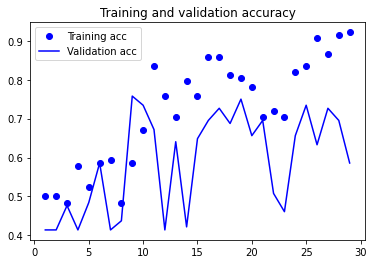

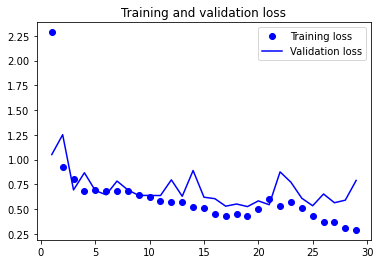

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_images, test_labels)

1/4 [======>.......................] - ETA: 0s - loss: 0.9023 - acc: 0.5312WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_test_batch_end` time: 0.0302s). Check your callbacks.


4/4 [==============================] - 0s 34ms/step - loss: 0.7279 - acc: 0.5781


[0.7278906106948853, 0.578125]